In [ ]:
!pip install optuna
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
import requests
import time
import json
import pickle
from pathlib import Path
from google.colab import drive
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_optuna

import shap

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_name = "google/gemma-2-9b-it"
width = "16k"
layer = 31

def get_feature_descriptions(feature):
    layer_name = f"{layer}-gemmascope-res-{width}"
    model_name_neuronpedia = model_name.split("/")[1]
    url = f"https://www.neuronpedia.org/api/feature/{model_name_neuronpedia}/{layer_name}/{feature}"
    response = requests.get(url)
    output = response.json()["explanations"][0]["description"]
    time.sleep(0.5)
    return output

In [ ]:
data_filename = '/content/drive/MyDrive/thesis/data/depr_suic_google_gemma-2-9b-it_layer31_width16k.npz'
data_path = os.path.realpath(data_filename)
data = np.load(data_path, allow_pickle=True)
texts = data['texts'].tolist()
classes = data['classes'].tolist()
cont_activations = data["cont_activations"]
del data

In [ ]:
classes = [1 if x=='suicide' else 0 for x in classes]

In [ ]:
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    cont_activations, classes, texts,
    test_size=2500,
    random_state=42,
    stratify=classes
)

In [ ]:
X_train, X_val, y_train, y_val, texts_train, texts_val = train_test_split(
    X_train, y_train, texts_train,
    test_size=2500,
    random_state=42,
    stratify=y_train
)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, len(texts_val)

((35000, 16384), (2500, 16384), (2500, 16384), 2500)

In [ ]:
np.savez_compressed(
    '/content/drive/MyDrive/thesis/data/tran_val_test_split_main.npz',
    X_train=X_train, X_test=X_test, X_val=X_val,
    y_train=y_train, y_test=y_test, y_val=y_val,
    texts_train=texts_train, texts_val=texts_val, texts_test=texts_test
    )

In [ ]:
split = np.load('/content/drive/MyDrive/thesis/data/tran_val_test_split_main.npz')
X_train = split['X_train']
X_test = split['X_test']
X_val = split['X_val']
y_train = split['y_train']
y_test = split['y_test']
y_val = split['y_val']
texts_train = split['texts_train']
texts_test = split['texts_test']
texts_val = split['texts_val']
X_train.shape, X_val.shape, X_test.shape, len(texts_val)
del split

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 10))

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
clf = LGBMClassifier(
    random_state=42,
    n_jobs=6,
    verbose=-1
)

clf.fit(X_train, y_train)
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val), digits=3))
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.851     0.850     0.851      1250
           1      0.851     0.851     0.851      1250

    accuracy                          0.851      2500
   macro avg      0.851     0.851     0.851      2500
weighted avg      0.851     0.851     0.851      2500

              precision    recall  f1-score   support

           0      0.842     0.809     0.825      1250
           1      0.816     0.848     0.832      1250

    accuracy                          0.828      2500
   macro avg      0.829     0.828     0.828      2500
weighted avg      0.829     0.828     0.828      2500



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
results = {}
max_features_options = [1000, 500, 300, 200, 100, 50]

for max_features in tqdm(max_features_options):
    clf = LGBMClassifier(random_state=42, n_jobs=6, verbose=-1)
    clf.fit(X_train, y_train)

    selector = SelectFromModel(clf, prefit=True, max_features=max_features)
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)

    clf = LGBMClassifier(random_state=42, n_jobs=6, verbose=-1)
    clf.fit(X_train_selected, y_train)

    results[max_features] = {
        "val": classification_report(y_true=y_val, y_pred=clf.predict(X_val_selected), digits=3),
        "test": classification_report(y_true=y_test, y_pred=clf.predict(X_test_selected), digits=3)
    }

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

In [ ]:
for max_features in tqdm(max_features_options):
  print(f"--- Performance for {max_features} SAE features with LightGBM: \n\n")
  print(results[max_features]["val"])
  print("\n\n")
  print(results[max_features]["test"])
  print("\n\n\n")

  0%|          | 0/6 [00:00<?, ?it/s]

--- Performance for 1000 SAE features with LightGBM: 


              precision    recall  f1-score   support

           0      0.851     0.848     0.850      1250
           1      0.849     0.852     0.850      1250

    accuracy                          0.850      2500
   macro avg      0.850     0.850     0.850      2500
weighted avg      0.850     0.850     0.850      2500




              precision    recall  f1-score   support

           0      0.847     0.813     0.829      1250
           1      0.820     0.853     0.836      1250

    accuracy                          0.833      2500
   macro avg      0.833     0.833     0.833      2500
weighted avg      0.833     0.833     0.833      2500





--- Performance for 500 SAE features with LightGBM: 


              precision    recall  f1-score   support

           0      0.852     0.846     0.849      1250
           1      0.847     0.853     0.850      1250

    accuracy                          0.849      2500
   macro a

In [ ]:
clf = LGBMClassifier(random_state=42, n_jobs=6, verbose=-1)
clf.fit(X_train, y_train)

selector = SelectFromModel(clf, prefit=True, max_features=50)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

In [ ]:
selected_indices = selector.get_support(indices=True).tolist()

In [ ]:
np.savez_compressed(
    '/content/drive/MyDrive/thesis/data/selected_features_reduced_datasets_50.npz',
    X_train_selected=X_train_selected,
    X_val_selected=X_val_selected,
    X_test_selected=X_test_selected,
    selected_feature_indices=selected_indices
    )

In [ ]:
data = np.load('/content/drive/MyDrive/thesis/data/selected_features_reduced_datasets_50.npz')
X_train_selected = data['X_train_selected']
X_val_selected = data['X_val_selected']
X_test_selected = data['X_test_selected']
selected_indices=data['selected_feature_indices']
X_train_selected.shape, X_val_selected.shape, X_test_selected.shape, len(selected_indices)
del data

((34988, 500), (2500, 500), (2500, 500))

In [ ]:
train_data = lgb.Dataset(X_train_selected, label=y_train)
valid_data = lgb.Dataset(X_val_selected, label=y_val, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
}

tuner = lgb_optuna.LightGBMTuner(
    params,
    train_data,
    valid_sets=valid_data,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50)],
    optuna_seed=42,
    show_progress_bar=True,
)

tuner.run()

[I 2026-01-29 19:49:57,439] A new study created in memory with name: no-name-d30819fe-7df3-470b-b8b1-21e463678ba2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.363535:  14%|#4        | 1/7 [00:00<00:03,  1.61it/s]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.363535
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.362583:  29%|##8       | 2/7 [00:01<00:04,  1.25it/s]

Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.362583
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.360603:  43%|####2     | 3/7 [00:02<00:03,  1.32it/s]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.360603
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.360603:  57%|#####7    | 4/7 [00:02<00:02,  1.39it/s]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.36094
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.360603:  71%|#######1  | 5/7 [00:03<00:01,  1.33it/s]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.361318
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.359071:  86%|########5 | 6/7 [00:07<00:01,  1.69s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.359071
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.358328: 100%|##########| 7/7 [00:07<00:00,  1.14s/it]


Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328


num_leaves, val_score: 0.358328:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:   5%|5         | 1/20 [00:01<00:22,  1.19s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.361466
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  10%|#         | 2/20 [00:03<00:30,  1.71s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.365931
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  15%|#5        | 3/20 [00:05<00:30,  1.78s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.364639
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  20%|##        | 4/20 [00:05<00:22,  1.39s/it]

Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.360387
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  25%|##5       | 5/20 [00:06<00:18,  1.21s/it]

Early stopping, best iteration is:
[504]	valid_0's binary_logloss: 0.362639
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  30%|###       | 6/20 [00:08<00:18,  1.30s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.361799
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  35%|###5      | 7/20 [00:12<00:31,  2.40s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.364623
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  40%|####      | 8/20 [00:13<00:23,  1.94s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.360722
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  45%|####5     | 9/20 [00:16<00:21,  1.99s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.366615
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  50%|#####     | 10/20 [00:17<00:19,  1.91s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.360003
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  55%|#####5    | 11/20 [00:18<00:14,  1.61s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.359667
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  60%|######    | 12/20 [00:20<00:14,  1.79s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.371467
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  65%|######5   | 13/20 [00:22<00:12,  1.75s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.360075
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  70%|#######   | 14/20 [00:26<00:14,  2.41s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.361204
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  75%|#######5  | 15/20 [00:27<00:10,  2.04s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.362843
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  80%|########  | 16/20 [00:29<00:07,  1.89s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.364814
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  85%|########5 | 17/20 [00:29<00:04,  1.55s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.361378
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  90%|######### | 18/20 [00:31<00:03,  1.54s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.364169
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328:  95%|#########5| 19/20 [00:32<00:01,  1.46s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.361804
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358328: 100%|##########| 20/20 [00:33<00:00,  1.68s/it]


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.359986


bagging, val_score: 0.358328:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  10%|#         | 1/10 [00:00<00:07,  1.13it/s]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.359338
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  20%|##        | 2/10 [00:01<00:06,  1.20it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.361789
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  30%|###       | 3/10 [00:02<00:07,  1.01s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.360492
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  40%|####      | 4/10 [00:06<00:11,  1.92s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.36024
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  50%|#####     | 5/10 [00:07<00:07,  1.54s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.362161
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  60%|######    | 6/10 [00:07<00:04,  1.25s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.364018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  70%|#######   | 7/10 [00:08<00:03,  1.21s/it]

Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.360982
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  80%|########  | 8/10 [00:09<00:02,  1.09s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.361137
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328:  90%|######### | 9/10 [00:10<00:01,  1.04s/it]

Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.36328
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.358328: 100%|##########| 10/10 [00:11<00:00,  1.15s/it]


Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.362482


feature_fraction_stage2, val_score: 0.358328:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.358328:  33%|###3      | 1/3 [00:00<00:01,  1.23it/s]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.363147
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.358328:  67%|######6   | 2/3 [00:01<00:00,  1.16it/s]

Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.361612
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.358328: 100%|##########| 3/3 [00:02<00:00,  1.18it/s]


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.359636


regularization_factors, val_score: 0.358328:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:   5%|5         | 1/20 [00:00<00:17,  1.09it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  10%|#         | 2/20 [00:01<00:16,  1.09it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  15%|#5        | 3/20 [00:05<00:37,  2.23s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  20%|##        | 4/20 [00:06<00:27,  1.69s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  25%|##5       | 5/20 [00:07<00:20,  1.38s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  30%|###       | 6/20 [00:08<00:16,  1.20s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  35%|###5      | 7/20 [00:09<00:14,  1.09s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  40%|####      | 8/20 [00:09<00:12,  1.02s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  45%|####5     | 9/20 [00:10<00:10,  1.03it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  50%|#####     | 10/20 [00:11<00:09,  1.09it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  55%|#####5    | 11/20 [00:12<00:07,  1.14it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  60%|######    | 12/20 [00:13<00:07,  1.14it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  65%|######5   | 13/20 [00:14<00:06,  1.14it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  70%|#######   | 14/20 [00:14<00:05,  1.14it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  75%|#######5  | 15/20 [00:18<00:08,  1.63s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  80%|########  | 16/20 [00:19<00:05,  1.47s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  85%|########5 | 17/20 [00:20<00:03,  1.28s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  90%|######### | 18/20 [00:21<00:02,  1.14s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.359814
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328:  95%|#########5| 19/20 [00:21<00:01,  1.04s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.358328
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.358328: 100%|##########| 20/20 [00:22<00:00,  1.14s/it]


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.359814


min_child_samples, val_score: 0.358328:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.357577:  20%|##        | 1/5 [00:00<00:03,  1.03it/s]

Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.357577
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.357577:  40%|####      | 2/5 [00:01<00:02,  1.06it/s]

Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.358284
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.357577:  60%|######    | 3/5 [00:02<00:01,  1.05it/s]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.358602
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.357577:  80%|########  | 4/5 [00:03<00:00,  1.09it/s]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.357729
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.357577: 100%|##########| 5/5 [00:04<00:00,  1.07it/s]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.359936


In [ ]:
best_params = tuner.best_params
print(f"Best params: {best_params}")
print(f"Best score: {tuner.best_score}")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 4.659111325097862e-07, 'lambda_l2': 0.0014320519666824027, 'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50}
Best score: 0.35757675739162625


In [ ]:
with open('/content/drive/MyDrive/thesis/data/best_params_lgb_50_selected.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [ ]:
with open('/content/drive/MyDrive/thesis/data/best_params_lgb_50_selected.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [ ]:
clf = LGBMClassifier(**best_params, random_state=42, n_jobs=6, verbose=-1)
clf.fit(X_train_selected, y_train)
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_selected), digits=3))
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_selected), digits=3))

              precision    recall  f1-score   support

           0      0.843     0.838     0.840      1250
           1      0.839     0.844     0.841      1250

    accuracy                          0.841      2500
   macro avg      0.841     0.841     0.841      2500
weighted avg      0.841     0.841     0.841      2500

              precision    recall  f1-score   support

           0      0.854     0.814     0.834      1250
           1      0.823     0.861     0.841      1250

    accuracy                          0.838      2500
   macro avg      0.838     0.838     0.838      2500
weighted avg      0.838     0.838     0.838      2500



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
clf = LGBMClassifier(random_state=42, n_jobs=6, verbose=-1)
clf.fit(X_train_selected, y_train)
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_selected), digits=3))
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_selected), digits=3))

              precision    recall  f1-score   support

           0      0.842     0.839     0.841      1250
           1      0.840     0.842     0.841      1250

    accuracy                          0.841      2500
   macro avg      0.841     0.841     0.841      2500
weighted avg      0.841     0.841     0.841      2500

              precision    recall  f1-score   support

           0      0.850     0.818     0.834      1250
           1      0.824     0.856     0.840      1250

    accuracy                          0.837      2500
   macro avg      0.837     0.837     0.837      2500
weighted avg      0.837     0.837     0.837      2500



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
with open('/content/drive/MyDrive/thesis/models/lightgbm/lgb_model_tuned_50_features.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
with open('/content/drive/MyDrive/thesis/models/lightgbm/lgb_model_tuned_50_features.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
shap_path = "/content/drive/MyDrive/thesis/data/shap_values.npz"

def compute_shap_in_batches(explainer, X, batch_size=10, save_path=None):
    shap_values_list = []
    for i in tqdm(range(0, X.shape[0], batch_size)):
        X_batch = X[i:i+batch_size]
        shap_values_list.append(explainer.shap_values(X_batch, check_additivity=False))
    shap_values = np.concatenate(shap_values_list, axis=0)
    if save_path:
        np.savez_compressed(save_path, shap_values)
    return shap_values

explainer = shap.TreeExplainer(clf)
shap_values = compute_shap_in_batches(explainer, X_val_selected, batch_size=100, save_path=shap_path)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Base value (expected value): {explainer.expected_value}")

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP values shape: (2500, 50)
Base value (expected value): -0.04468918794207231


In [ ]:
# data = np.load(shap_path)
# shap_values = data['arr_0']

In [ ]:
desc_cache_path = "/content/drive/MyDrive/thesis/data/feature_descriptions_cache_100_selected.json"

if os.path.exists(desc_cache_path):
    with open(desc_cache_path, "r") as f:
        feature_desc = json.load(f)
else:
    feature_desc = {}

def get_cached_description(idx):
    idx = selected_indices[idx]
    if str(idx) in feature_desc:
        return feature_desc[str(idx)]
    try:
        desc = get_feature_descriptions(idx)
    except Exception as e:
        desc = f"Feature {idx}"
    feature_desc[str(idx)] = desc
    return desc

In [ ]:
correlations = np.array([
    np.corrcoef(X_val_selected[:, i], shap_values[:, i])[0, 1]
    for i in range(X_val_selected.shape[1])
])

print(f"Positive correlations: {(correlations > 0).sum()}")
print(f"Negative correlations: {(correlations < 0).sum()}")

Positive correlations: 27
Negative correlations: 23


In [ ]:
positive_corr_mask = correlations > 0
positive_indices = np.where(positive_corr_mask)[0]

negative_corr_mask = correlations < 0
negative_indices = np.where(negative_corr_mask)[0]

positive_ranked = positive_indices[np.argsort(correlations[positive_indices])[::-1]]
negative_ranked = negative_indices[np.argsort(np.abs(correlations[negative_indices]))[::-1]]

top_n = 50
suicidal_idx = positive_ranked[:min(top_n, len(positive_ranked))]
depression_idx = negative_ranked[:min(top_n, len(negative_ranked))]

In [ ]:
print("Top 20 SUICIDAL IDEATION indicators (strongest positive correlations):")
for i in range(min(20, len(suicidal_idx))):
    idx = suicidal_idx[i]
    print(f"  {i+1}. Correlation: {correlations[idx]:+.3f}")
    print(f"     Feature: {get_cached_description(idx)}\n")

Top 20 SUICIDAL IDEATION indicators (strongest positive correlations):
  1. Correlation: +0.918
     Feature:  expressions of value or worthiness in relation to costs or effort

  2. Correlation: +0.857
     Feature: positive expressions about experiences or recommendations

  3. Correlation: +0.854
     Feature: instances of significant scientific or technical concepts related to detector technology

  4. Correlation: +0.854
     Feature:  mentions of COVID-19 and its impact

  5. Correlation: +0.851
     Feature:  references to feature selection methods in data analysis

  6. Correlation: +0.835
     Feature:  health and safety advice related to protection from threats

  7. Correlation: +0.800
     Feature:  numerical values related to time and significant events

  8. Correlation: +0.799
     Feature: terms and expressions related to suicide and depression

  9. Correlation: +0.786
     Feature: terms and references related to the COVID-19 pandemic and its impact

  10. Correlation

In [ ]:
print("\nTop 20 DEPRESSION indicators (strongest negative correlations):")
for i in range(min(20, len(depression_idx))):
    idx = depression_idx[i]
    print(f"  {i+1}. Correlation: {correlations[idx]:+.3f}")
    print(f"     Feature: {get_cached_description(idx)}\n")


Top 20 DEPRESSION indicators (strongest negative correlations):
  1. Correlation: -0.922
     Feature: terms related to depression and its associated medical terminology

  2. Correlation: -0.906
     Feature: instances of the word "you" and variations of connected phrases that express personal address or engagement

  3. Correlation: -0.866
     Feature:  formatted questions and responses

  4. Correlation: -0.852
     Feature:  references to depression and its associated symptoms, especially somatic symptoms

  5. Correlation: -0.843
     Feature: strong indications of feedback or comments in various contexts

  6. Correlation: -0.815
     Feature:  mentions of clothing items and related apparel concepts

  7. Correlation: -0.807
     Feature:  instances of legal terminology and formal structures related to court proceedings

  8. Correlation: -0.787
     Feature:  segments that indicate continuation or additional information

  9. Correlation: -0.782
     Feature:  references to pe

In [ ]:
suicidal_feature_names = [get_cached_description(i) for i in tqdm(suicidal_idx)]
depression_feature_names = [get_cached_description(i) for i in tqdm(depression_idx)]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
print(len(feature_desc))

with open(desc_cache_path, "w") as f:
    json.dump(feature_desc, f)

126


In [ ]:
base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value = base_value[1] if len(base_value) > 1 else base_value[0]

In [ ]:
expl_suicidal = shap.Explanation(
    values=shap_values[:, suicidal_idx],
    data=X_val_selected[:, suicidal_idx],
    base_values=np.full(len(shap_values), base_value),
    feature_names=suicidal_feature_names
)

In [ ]:
expl_depression = shap.Explanation(
    values=shap_values[:, depression_idx],
    data=X_val_selected[:, depression_idx],
    base_values=np.full(len(shap_values), base_value),
    feature_names=depression_feature_names
)

In [ ]:
n_display = 25

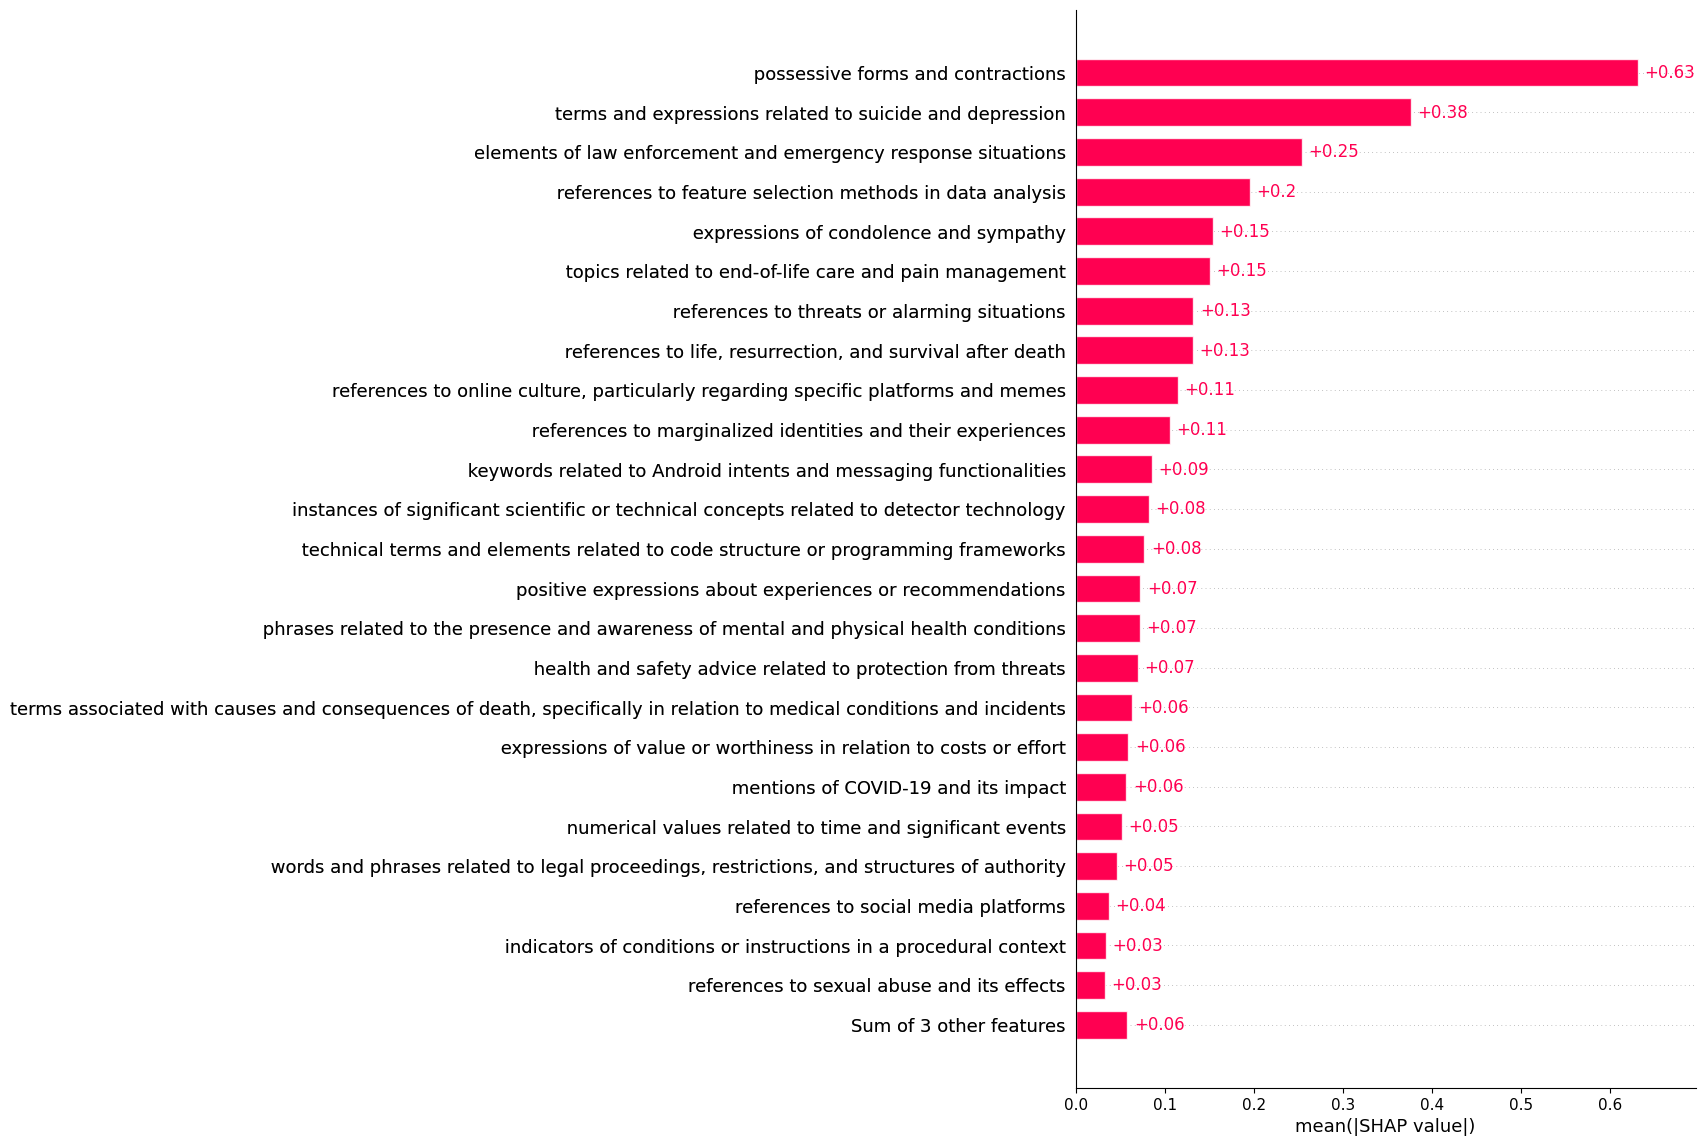

In [ ]:
shap.plots.bar(expl_suicidal, max_display=n_display)

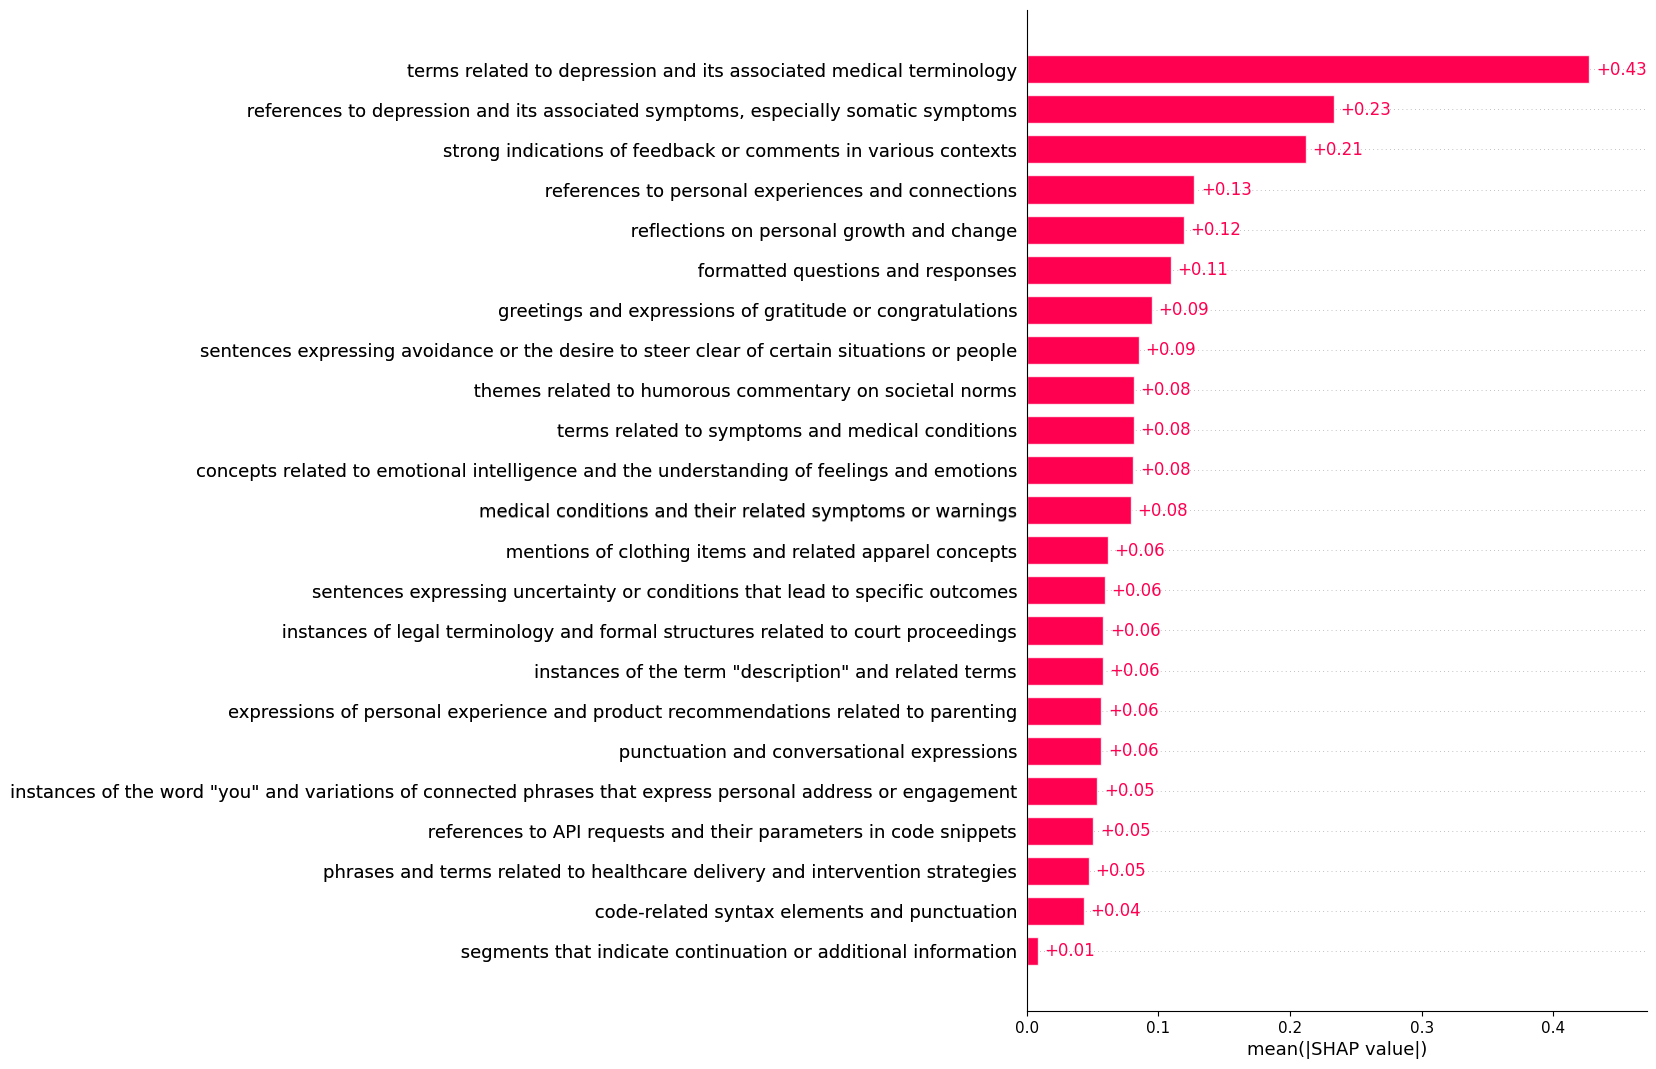

In [ ]:
shap.plots.bar(expl_depression, max_display=n_display)

/tmp/ipython-input-1003169820.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


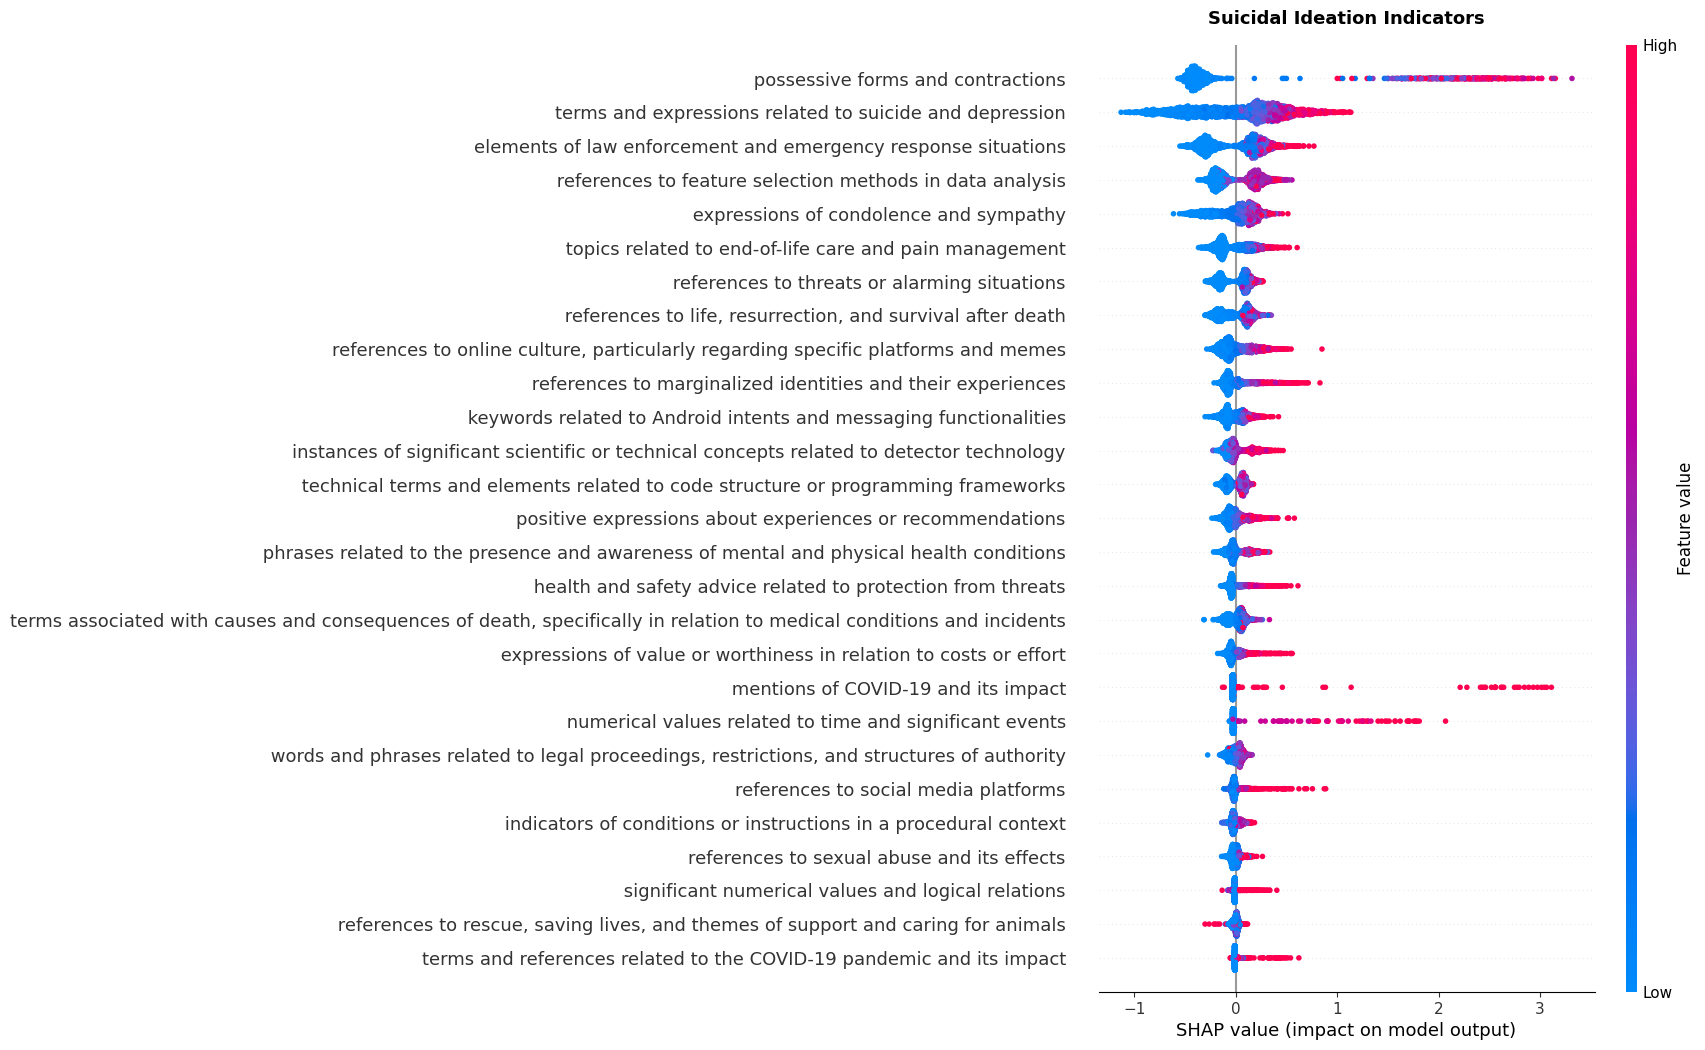

In [ ]:
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(expl_suicidal, max_display=30, show=False)
plt.title(
    "Suicidal Ideation Indicators",
    fontsize=13,
    fontweight='bold',
    pad=15
    )
plt.tight_layout()
plt.show()

/tmp/ipython-input-3930110244.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


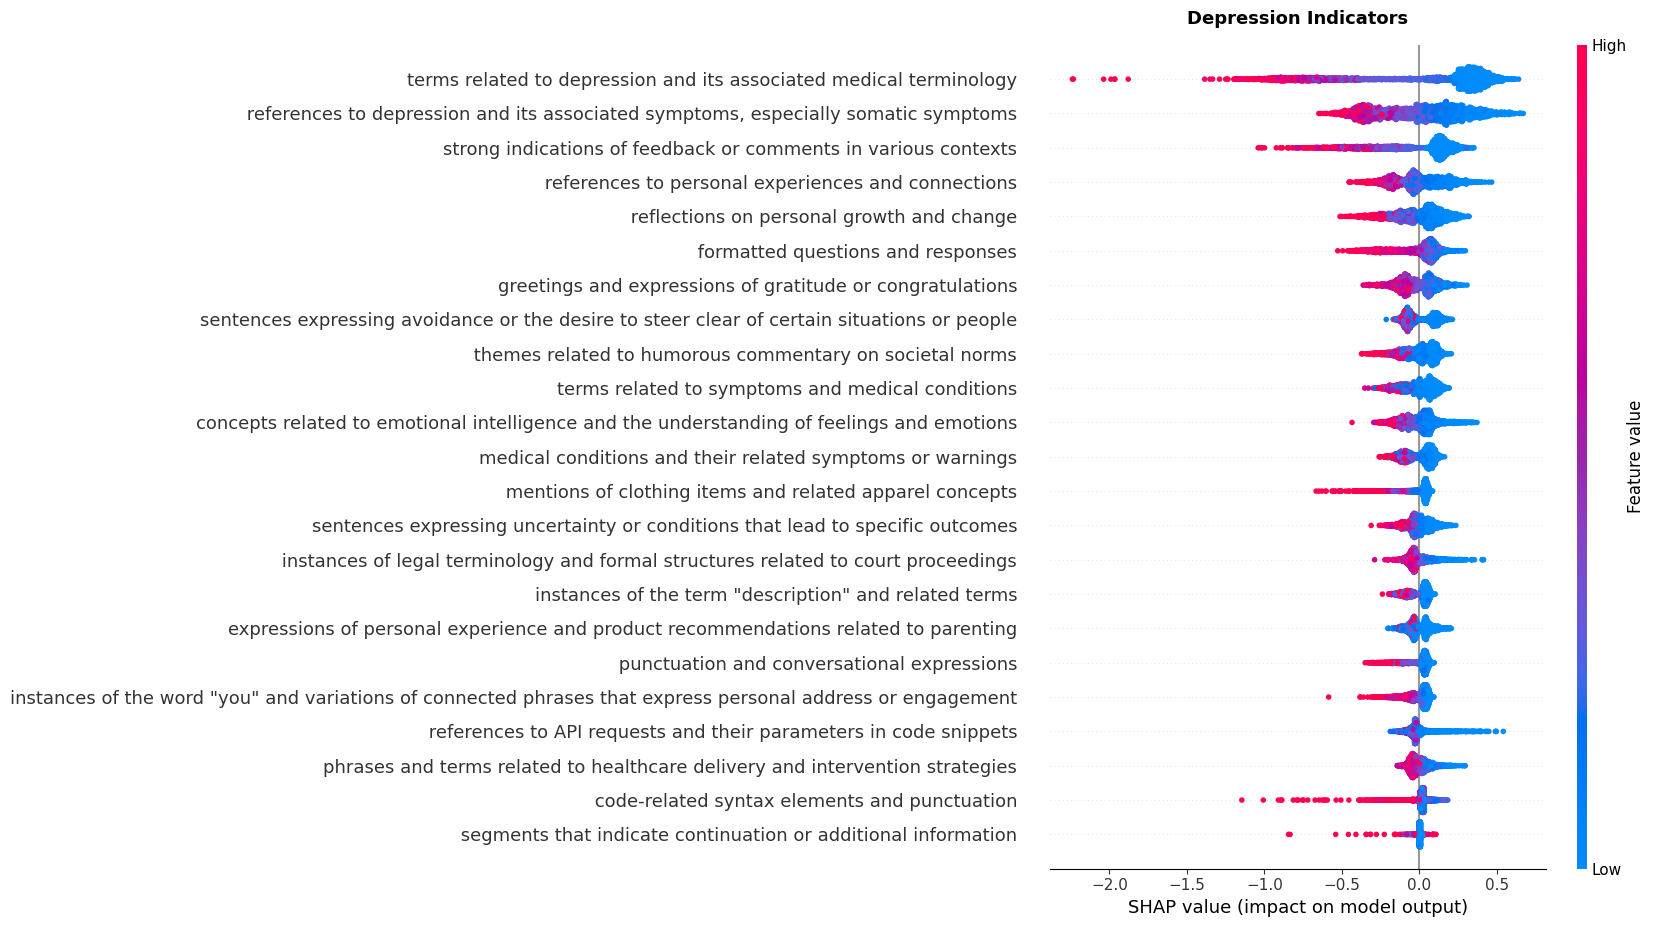

In [ ]:
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(expl_depression, max_display=30, show=False)
plt.title(
    "Depression Indicators",
    fontsize=13,
    fontweight='bold',
    pad=15
    )
plt.tight_layout()
plt.show()

In [ ]:
from pprint import pprint

("I don't have anyone to be honest to... (long post)When I think about my "
 'depression, I always question it. I am a contradiction. Am I really '
 'depressed? I have all of the common symptoms -- but my self-doubt is '
 "immense. What if I'm doing this for attention? What if I'm actually not "
 "depressed? What if I'm just lazy, stupid, needy, and seeking for attention? "
 "I can't talk to anyone about this, because that's selfish of me. And I'm not "
 'even sure if I am coherent anymore.\n'
 '\n'
 "I don't have anyone to go to who can give me the compassion that I've longed "
 'for. Practical answers do not register for me -- at least not the ones my '
 'boyfriend gives me. And my family -- ha -- they treat me like an outcast as '
 'if they\'re bitter and angry that I am "depressed". They call me crazy and '
 'treat me as if I am a dysfunctional, malfunctioning (barely) human being. '
 "It's subtle, but it's still there. Just the slight tone of their voice, the "
 'way they address 

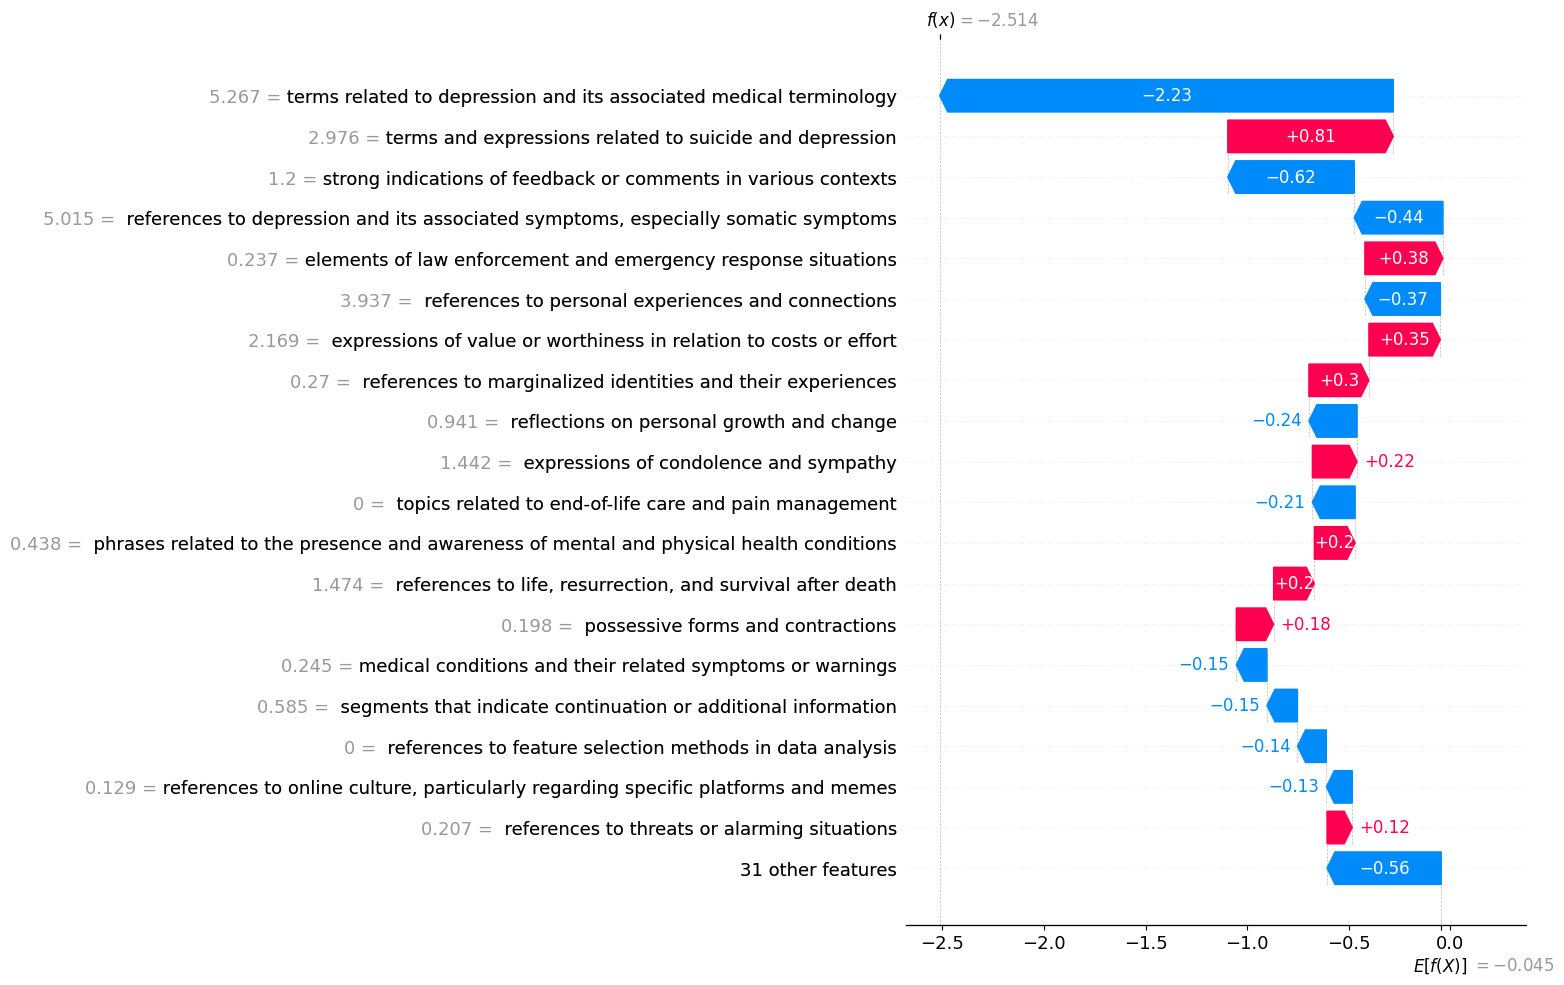

In [ ]:
sample_idx = 15
pprint(str(texts_val[sample_idx]))
print("\n\n", f"Label:\n{'Suicide' if y_val[sample_idx] == 1 else 'Depression'}\n")

expl_combined = shap.Explanation(
    values=shap_values[sample_idx, :],
    data=X_val_selected[sample_idx, :],
    base_values=base_value,
    feature_names=[get_cached_description(i) for i in range(len(shap_values[sample_idx]))]
)
shap.plots.waterfall(expl_combined, max_display=20)